In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import struct
import pandas as pd
import scipy
from scipy.signal import find_peaks
from matplotlib import colors
from matplotlib import ticker
import matplotlib as plt
import requests, zipfile
import io
import os
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.fft import fft, fftfreq

This file contains the exact same filtering function as vdColdbox_april_cosmic_compare_cpu.ipynb. It's just more comfortable to look at the raw data and generate plots from here, since there's no feature extraction.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def substract_peds(row):
    return row - np.argmax(np.bincount(row))

In [ ]:
from scipy.signal import find_peaks
import gc

def filter_rows(data, param, threshold=0, window_size=0):
  print(data.shape[0])
  print(data.shape[1])
  filtered_data = []
  peak_data = []
  for row in data:
      row = substract_peds(row)
      if 400 < np.max(row) < 12.5e3:
          filtered_data.append(row)
  filtered_data = np.array(filtered_data)
  print(filtered_data.shape[0])
  print(filtered_data.shape[1])
  del data
  gc.collect()
  for row in filtered_data:
    if param == 1:
      index_range = slice(100, 1900)
      peaks, _ = find_peaks(row[index_range], height=100)
      peaks = peaks + index_range.start
    else:
      index_range = slice(100, 52000)
      peaks, _ = find_peaks(row[index_range], height=100)
      peaks = peaks + index_range.start
    print(len(peaks))
    for i, peak in enumerate(peaks):
      if peak in (0, len(row) - 1) or (i > 0 and peaks[i - 1] == peak - 1) or (i < len(peaks) - 1 and peaks[i + 1] == peak + 1):
        continue
      threshold = 0.1 * row[peak]
      left_edge_ind = peak
      while left_edge_ind > max(0, peak-100) and row[left_edge_ind] > threshold:
        left_edge_ind -= 1
      right_edge_ind = peak
      while right_edge_ind < min(len(row)-1, peak+100) and row[right_edge_ind] > threshold:
        right_edge_ind += 1
      if row[left_edge_ind] <= threshold and row[right_edge_ind] <= threshold:
        peak_data.append(row[left_edge_ind:right_edge_ind])
  print(len(peak_data))
  del filtered_data
  gc.collect()
  return peak_data

In [ ]:
def load_in_chunks(filename, chunk_size, param, upper_limit = None):
    data = np.load(filename, mmap_mode='r').astype(np.int16)
    data[data < 0] = 0
    data = filter_rows(data, param)
    plt.plot(data[0])
    plt.show()
    plt.plot(data[1])
    plt.show()
    plt.plot(data[2])
    plt.show()
    plt.plot(data[3])
    plt.show()
    total_size = len(data)
    for start in range(0, total_size, chunk_size):
        end = min(start + chunk_size, total_size) if upper_limit is None else min(start + chunk_size, upper_limit, total_size)
        chunk = pd.DataFrame(data[start:end])
        chunk = chunk[(chunk != 0).any(axis=1)]
        if not chunk.empty:
            yield chunk

In [ ]:
!pip install ipdb
import ipdb
from scipy.signal import find_peaks, chirp, peak_widths

def prompt_fraction(data):
    prompt_fraction = []
    all_values = []
    #bprompt = [0] * len(data)
    for i in range(len(data)):
        signal = data[i][~np.isnan(data[i])]
        peak_index = np.argmax(signal)
        width = peak_widths(signal, [peak_index], rel_height=0.35)[0]
        eall = len(signal)
        bprompt = np.argmax(np.gradient(signal))
        endprompt = int(peak_index + width[0]/ 2)
        endprompt = min(endprompt, eall - 1)
        pr = signal[bprompt:endprompt]
        pr = pr[pr > 0]
        ali = signal[bprompt:eall]
        ali = ali[ali > 0]
        prompt_fraction.append(np.sum(pr) / np.sum(ali))
        all_values.append(np.sum(ali))
        if np.sum(pr) / np.sum(ali) == 1:
          plt.plot(data[i])
          plt.show()
          ipdb. set_trace()

    return np.array(prompt_fraction), np.array(all_values)

In [ ]:

def prompt_fraction_v(data, r1):
    prompt_fraction = []
    all = []

    for i in range(len(data)):
        signal = data[i][~np.isnan(data[i])]
        rising_edge = np.argmax(np.gradient(signal))
        bprompt, endprompt  = rising_edge+10, rising_edge+ r1
        eall = len(signal)
        pr = signal[bprompt:endprompt]
        pr = pr[pr > 0]
        ali = signal[bprompt:eall]
        ali = ali[ali > 0]
        prompt_fraction.append( np.sum(pr)/ np.sum(ali))
        all.append(np.sum(ali))


    return np.array(prompt_fraction), np.array(all)

In [ ]:
from scipy.signal import find_peaks, chirp, peak_widths

def prompt_fraction_around_peak(data):
    prompt_fraction = []
    all_values = []
    for row in data:
        row = row[~np.isnan(row)]
        eall = len(row)
        peak_index = np.argmax(row)
        rising_edge = np.argmax(np.gradient(row))
        width = peak_widths(row, [peak_index], rel_height=0.35)[0]
        l = (width[0] / 2).astype(int)
        #l = ((peak_index-rising_edge) / 2).astype(int)
        bprompt = max(0, peak_index - l)
        endprompt = min(eall, peak_index + l)
        pr = row[bprompt:endprompt]
        pr = pr[pr > 0]

        ali = row[0:eall]
        ali = ali[ali > 0]

        prompt_fraction.append(np.sum(pr) / np.sum(ali))
        all_values.append(np.sum(ali))

    return np.array(prompt_fraction), all_values

In [ ]:
from scipy.stats import kurtosis

def prompt_calculation(df):
  data = df.values
  print(data.shape)
  prompt1 = prompt_fraction(data)
  prompt2 = prompt_fraction_around_peak(data)
  prompt3 = prompt_fraction_v(data, 40)
  kurt = kurtosis(data, axis=1)
  data = {
    'Prompt1': prompt1[0],
    'All1': prompt1[1],
    'Prompt2': prompt2[0],
    'All2': prompt2[1],
    'Kurt': kurt,
    'Prompt3': prompt3[0],
    'All3': prompt3[1]
    }
  df_features = pd.DataFrame(data)
  return df_features

4200
262144
2599
262144
48
18
21
155
77
23
160
56
28
54
96
22
81
66
9
83
60
40
83
91
71
18
47
56
99
41
44
27
64
114
132
28
33
35
50
71
119
48
123
75
40
23
51
15
50
113
44
121
34
55
46
17
30
43
53
48
4
33
35
18
43
59
63
21
47
38
81
6
69
69
36
30
48
34
162
16
22
56
78
44
52
24
9
46
17
25
40
31
50
37
43
42
13
81
24
53
25
22
25
84
52
41
34
19
26
55
68
1
1
1
13
44
87
80
25
53
54
83
57
38
37
36
63
1
0
26
105
51
12
79
34
11
51
47
74
40
13
38
2
30
24
78
40
28
17
35
43
16
39
61
45
21
33
46
7
29
83
35
63
31
33
46
49
105
66
43
104
61
46
36
25
21
66
111
83
42
67
101
19
54
13
103
43
36
54
31
30
57
52
57
49
43
18
20
11
19
8
72
42
19
20
119
34
75
87
58
68
23
62
9
66
70
58
47
40
122
6
67
33
34
89
72
80
2
52
87
22
13
41
73
58
64
0
40
101
43
67
13
51
36
63
59
24
99
31
8
94
9
101
4
58
46
39
65
84
109
81
118
38
130
26
3
1
68
61
126
51
3
74
90
56
34
36
61
25
9
23
93
26
130
11
21
39
2
65
86
43
104
31
14
20
62
28
36
2
81
112
39
41
70
33
76
56
18
36
56
27
54
26
80
38
21
21
38
58
39
30
63
21
39
30
73
62
41
85


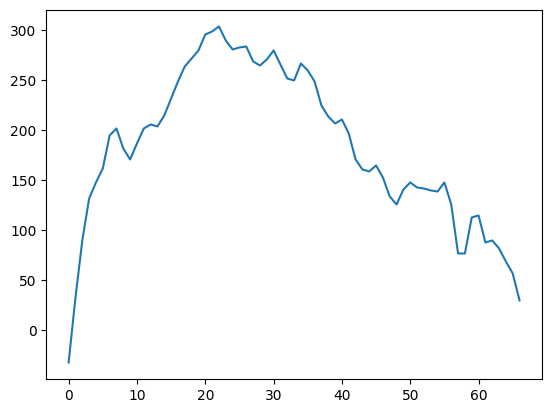

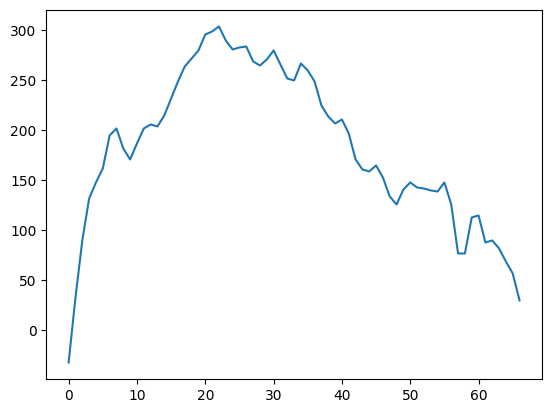

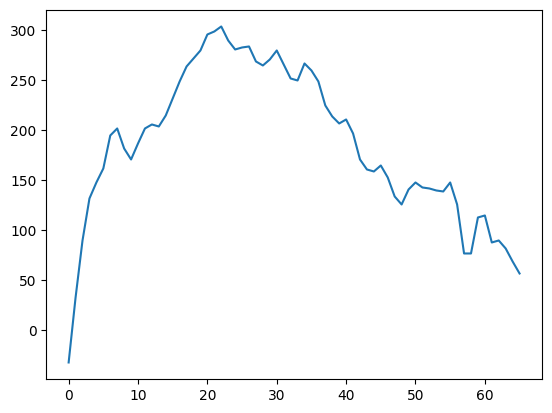

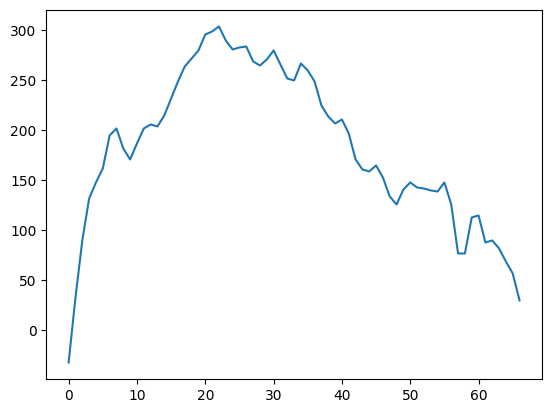

(500, 197)
(500, 7)
(500, 197)
(500, 7)
(500, 196)
(500, 7)
(500, 196)
(500, 7)
(500, 195)
(500, 7)
(500, 185)
(500, 7)
(500, 196)
(500, 7)
(500, 198)
(500, 7)
(500, 187)
(500, 7)
(500, 194)
(500, 7)
(500, 192)
(500, 7)
(500, 196)
(500, 7)
(500, 193)
(500, 7)
(500, 191)
(500, 7)
(500, 189)
(500, 7)
(500, 187)
(500, 7)
(500, 188)
(500, 7)
(500, 196)
(500, 7)
(500, 193)
(500, 7)
(500, 193)
(500, 7)
(500, 186)
(500, 7)
(500, 189)
(500, 7)
(500, 184)
(500, 7)
(500, 193)
(500, 7)
(500, 198)
(500, 7)
(500, 175)
(500, 7)
(500, 196)
(500, 7)
(500, 177)
(500, 7)
(500, 196)
(500, 7)
(500, 190)
(500, 7)
(500, 196)
(500, 7)
(500, 188)
(500, 7)
(500, 194)
(500, 7)
(500, 189)
(500, 7)
(500, 187)
(500, 7)
(500, 189)
(500, 7)
(500, 191)
(500, 7)
(500, 190)
(500, 7)
(500, 192)
(500, 7)
(500, 192)
(500, 7)
(500, 189)
(500, 7)
(500, 184)
(500, 7)
(500, 188)
(500, 7)
(500, 200)
(500, 7)
(500, 187)
(500, 7)
(500, 176)
(500, 7)
(500, 198)
(500, 7)
(500, 196)
(500, 7)
(500, 197)
(500, 7)
(500, 176)
(500, 7)


<ipython-input-8-b085d51e20a8>:14: RuntimeWarning: invalid value encountered in scalar divide
  prompt_fraction.append( np.sum(pr)/ np.sum(ali))


(500, 195)
(500, 7)
(500, 181)
(500, 7)
(500, 197)
(500, 7)
(500, 183)
(500, 7)
(500, 194)
(500, 7)
(500, 190)
(500, 7)
(500, 190)
(500, 7)
(500, 191)
(500, 7)
(500, 191)
(500, 7)
(500, 191)
(500, 7)
(500, 194)
(500, 7)
(500, 197)
(500, 7)
(500, 196)
(500, 7)
(500, 193)
(500, 7)
(500, 190)
(500, 7)
(500, 188)
(500, 7)
(500, 192)
(500, 7)
(500, 193)
(500, 7)
(500, 192)
(500, 7)
(500, 197)
(500, 7)
(500, 197)
(500, 7)
(500, 197)
(500, 7)
(500, 191)
(500, 7)
(500, 191)
(500, 7)
(500, 197)
(500, 7)
(500, 197)
(500, 7)
(500, 192)
(500, 7)
(500, 176)
(500, 7)
(500, 190)
(500, 7)
(500, 183)
(500, 7)
(500, 196)
(500, 7)
(500, 196)
(500, 7)
(500, 194)
(500, 7)
(500, 184)
(500, 7)
(500, 194)
(500, 7)
(500, 177)
(500, 7)
(500, 197)
(500, 7)
(500, 183)
(500, 7)
(500, 195)
(500, 7)
(500, 197)
(500, 7)
(500, 200)
(500, 7)
(500, 198)
(500, 7)
(500, 197)
(500, 7)
(500, 189)
(500, 7)
(500, 199)
(500, 7)
(500, 196)
(500, 7)
(500, 188)
(500, 7)
(500, 193)
(500, 7)
(500, 190)
(500, 7)
(500, 194)
(500, 7)


In [ ]:
filename = '/content/drive/MyDrive/lab_adi/adc_data_run_25066_ch_40_all.npy'
chunk_size = 500
output_file = '/content/drive/MyDrive/lab_adi/processed_data_negative.csv'

with open(output_file, 'w') as f:
    pd.DataFrame().to_csv(f, index=False)

for i, chunk in enumerate(load_in_chunks(filename, chunk_size, 0, None)):
    processed_chunk = prompt_calculation(chunk)
    print(processed_chunk.shape)
    if i == 0:
        processed_chunk.to_csv(output_file, mode='a', header=True, index=False)
    else:
        processed_chunk.to_csv(output_file, mode='a', header=False, index=False)

Streaming output truncated to the last 5000 lines.
0
0
0
0
0
11
13
0
0
0
10
0
0
0
14
0
0
0
0
0
0
0
0
6
0
0
0
0
0
0
0
0
0
0
0
0
0
0
26
0
4
9
0
0
0
0
0
0
0
0
2
0
0
0
0
0
4
1
0
0
0
2
0
0
0
0
0
0
0
7
8
23
21
41
12
31
12
27
23
0
1
20
24
0
3
1
0
44
40
54
10
1
32
0
9
0
4
10
0
54
13
28
27
0
19
9
50
34
16
34
25
0
20
31
93
21
6
23
17
4
30
0
12
14
9
4
18
2
39
23
11
12
19
14
15
25
17
19
29
11
17
48
22
5
10
47
34
25
26
34
18
18
12
9
25
3
27
48
23
4
41
5
2
22
7
29
0
16
35
30
4
0
14
28
22
5
6
31
7
53
22
16
36
1
8
22
69
3
0
32
1
0
38
17
32
20
34
16
15
36
15
31
15
39
32
0
14
57
0
0
1
7
0
13
15
9
5
13
11
16
5
21
22
6
13
4
25
76
2
67
21
0
0
62
15
4
4
0
12
9
15
3
42
24
3
46
0
11
0
35
39
44
18
25
12
5
26
0
4
10
3
33
31
25
28
16
14
1
11
0
12
26
5
2
12
27
36
10
2
29
38
8
40
0
37
27
9
0
26
5
8
34
21
3
27
24
12
12
22
12
57
22
44
0
21
7
0
28
4
0
41
8
4
66
48
19
30
22
12
28
2
15
22
5
9
18
1
23
6
23
43
29
0
19
0
7
20
1
0
0
18
36
3
0
29
20
17
15
6
3
27
14
0
14
2
0
10
8
7
28
6
41
0
0
0
41
36
5
11
0
0
0
0
0
0
0
0
0


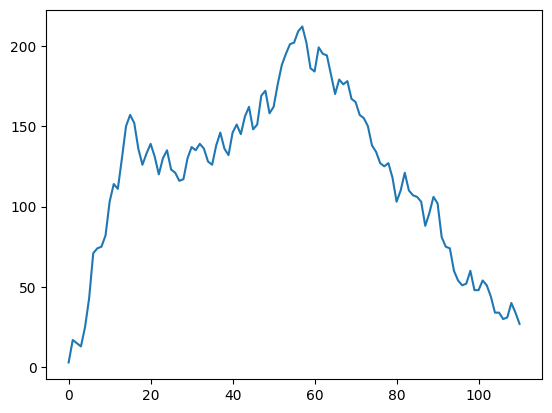

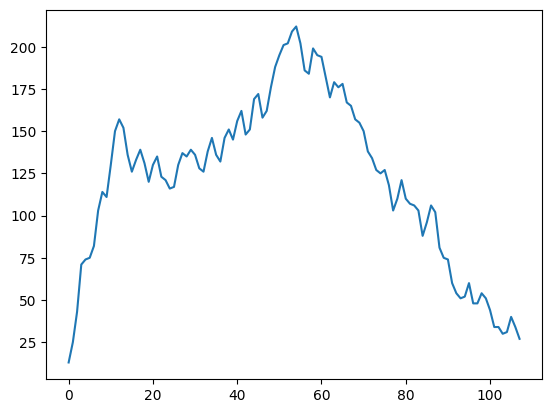

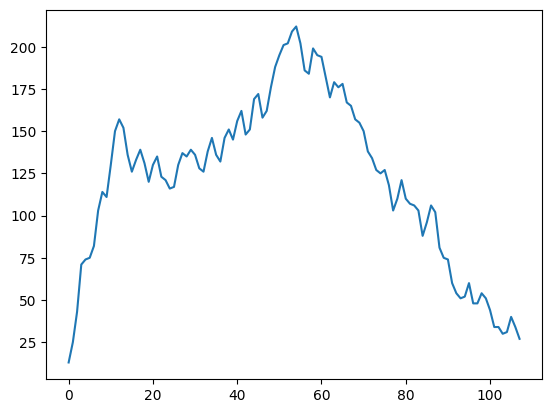

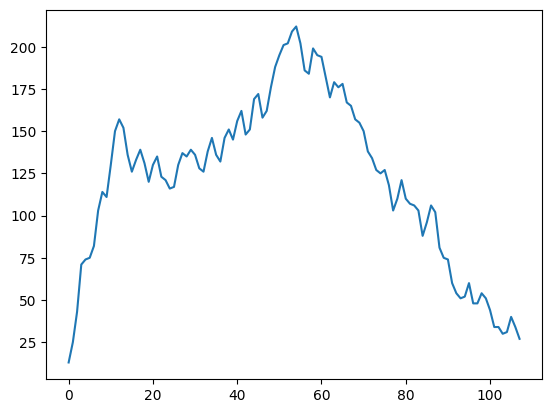

(500, 192)
(500, 7)
(500, 183)
(500, 7)
(500, 188)
(500, 7)
(500, 183)
(500, 7)
(500, 182)
(500, 7)
(500, 185)
(500, 7)
(500, 195)
(500, 7)
(500, 189)
(500, 7)
(500, 196)
(500, 7)
(500, 186)
(500, 7)
(500, 189)
(500, 7)
(500, 192)
(500, 7)
(500, 199)
(500, 7)
(500, 193)
(500, 7)
(500, 196)
(500, 7)
(500, 195)
(500, 7)
(500, 197)
(500, 7)
(500, 196)
(500, 7)
(500, 189)
(500, 7)
(500, 200)
(500, 7)
(500, 188)
(500, 7)
(500, 197)
(500, 7)
(500, 194)
(500, 7)
(500, 195)
(500, 7)
(500, 196)
(500, 7)
(500, 194)
(500, 7)
(500, 188)
(500, 7)
(500, 193)


<ipython-input-8-b085d51e20a8>:14: RuntimeWarning: invalid value encountered in scalar divide
  prompt_fraction.append( np.sum(pr)/ np.sum(ali))


(500, 7)
(500, 192)
(500, 7)
(500, 190)
(500, 7)
(500, 195)
(500, 7)
(500, 197)
(500, 7)
(500, 193)
(500, 7)
(500, 184)
(500, 7)
(500, 196)
(500, 7)
(500, 192)
(500, 7)
(500, 191)
(500, 7)
(500, 184)
(500, 7)
(500, 192)
(500, 7)
(500, 196)
(500, 7)
(500, 177)
(500, 7)
(500, 198)
(500, 7)
(500, 194)
(500, 7)
(500, 195)
(500, 7)
(500, 193)
(500, 7)
(500, 198)
(500, 7)
(500, 186)
(500, 7)
(500, 194)
(500, 7)
(500, 191)
(500, 7)
(500, 190)
(500, 7)
(500, 196)
(500, 7)
(500, 186)
(500, 7)
(500, 186)
(500, 7)
(500, 191)
(500, 7)
(500, 196)
(500, 7)
(500, 192)
(500, 7)
(500, 195)
(500, 7)
(500, 192)
(500, 7)
(500, 197)
(500, 7)
(500, 192)
(500, 7)
(500, 189)
(500, 7)
(500, 193)
(500, 7)
(500, 198)
(500, 7)
(500, 186)
(500, 7)
(500, 195)
(500, 7)
(500, 199)
(500, 7)
(500, 195)
(500, 7)
(500, 199)
(500, 7)
(500, 196)
(500, 7)
(500, 187)
(500, 7)
(500, 196)
(500, 7)
(500, 199)
(500, 7)
(500, 197)
(500, 7)
(500, 193)
(500, 7)
(500, 197)
(500, 7)
(500, 198)
(500, 7)
(500, 195)
(500, 7)
(500, 196)


In [ ]:
filename = '/content/drive/MyDrive/lab_adi/adc_data_run_25036_ch_40_all.npy'
chunk_size = 500
output_file = '/content/drive/MyDrive/lab_adi/processed_data_positive.csv'

with open(output_file, 'w') as f:
    pd.DataFrame().to_csv(f, index=False)

for i, chunk in enumerate(load_in_chunks(filename, chunk_size, 1, None)):
    processed_chunk = prompt_calculation(chunk)
    print(processed_chunk.shape)
    if i == 0:
        processed_chunk.to_csv(output_file, mode='a', header=True, index=False)
    else:
        processed_chunk.to_csv(output_file, mode='a', header=False, index=False)


38146
65536
808
65536
2
0
0
0
0
0
0
15
0
0
7
0
3
0
0
1
0
0
0
0
13
0
0
21
0
0
0
0
0
0
0
15
0
0
0
4
4
23
0
16
0
14
0
0
28
0
0
4
0
0
0
0
17
0
0
0
0
0
15
0
0
0
0
0
0
0
0
0
10
0
22
0
0
23
0
31
0
0
12
0
4
0
0
0
0
0
0
0
0
17
0
0
0
13
0
0
0
0
0
0
0
0
20
0
0
0
0
0
28
0
0
0
0
0
0
0
17
0
0
30
0
407
0
0
0
18
11
0
3
0
0
0
21
7
0
22
25
0
3
0
0
0
0
10
11
0
0
0
2
0
0
10
0
0
0
9
0
4
0
0
0
0
0
0
7
0
0
0
21
0
160
0
0
3
0
9
11
0
0
18
0
0
0
0
0
0
5
0
0
0
1
0
20
8
0
2
0
0
0
2
24
399
0
0
0
0
10
16
0
0
0
0
0
0
3
0
0
0
0
2
4
29
0
0
0
20
0
9
16
0
0
0
0
0
0
0
0
0
3
30
4
0
0
0
0
2
0
0
0
358
0
17
0
21
0
0
18
2
0
0
390
15
31
0
19
0
0
0
16
0
33
2
0
0
0
3
0
0
0
0
9
5
0
0
14
0
0
0
28
0
17
4
0
17
0
3
8
0
0
335
0
0
0
17
0
0
0
0
0
0
0
0
0
21
0
0
0
4
0
3
0
17
0
9
0
0
0
0
0
0
2
0
0
0
0
15
0
0
0
20
0
0
0
0
0
0
5
3
0
0
0
0
0
0
0
0
0
5
0
0
0
0
18
9
7
0
0
0
0
1
0
0
1
0
0
0
4
0
6
0
0
0
0
0
0
0
28
5
0
1
0
0
0
0
14
0
0
0
4
0
0
0
19
22
22
3
0
0
4
0
0
0
0
14
0
0
0
27
1
15
0
0
0
4
0
0
0
0
0
0
0
0
0
6
0
0
0
5
20
0
0
0
0
17
5
30
0
20


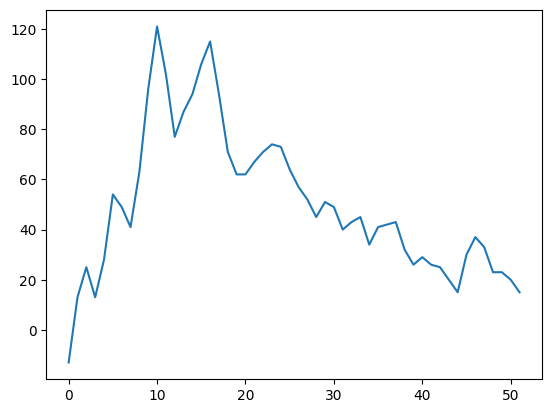

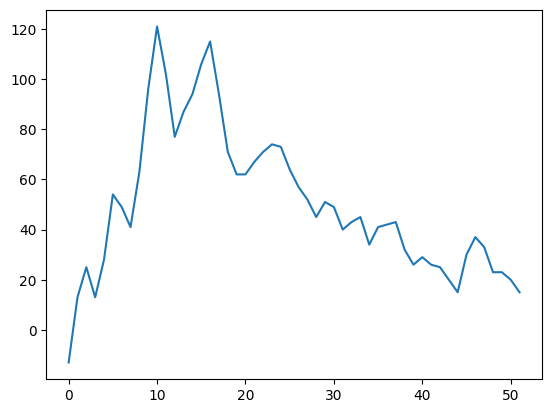

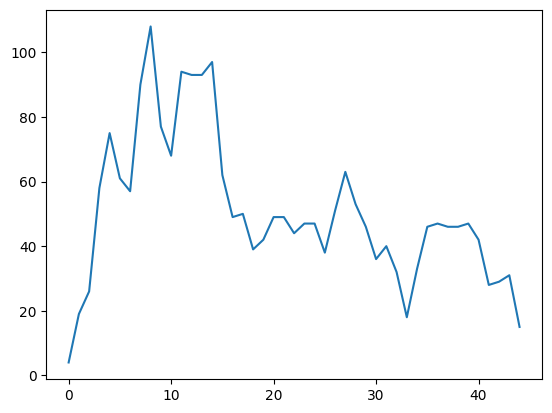

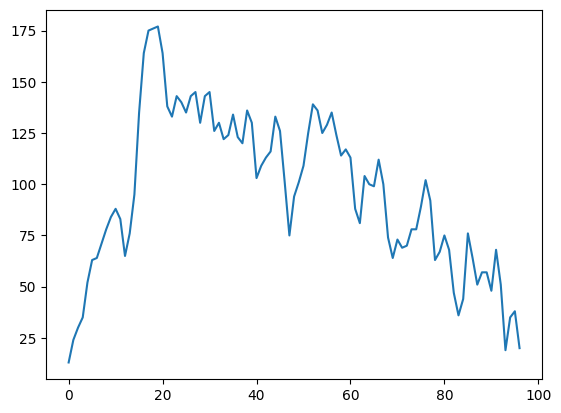

(500, 187)
(500, 7)
(500, 194)
(500, 7)
(500, 196)
(500, 7)
(114, 170)
(114, 7)


In [ ]:
filename = '/content/drive/MyDrive/lab_adi/adc_data_run_25071_ch_37_all.npy'
chunk_size = 500
output_file = '/content/drive/MyDrive/lab_adi/processed_data_positive.csv'

for i, chunk in enumerate(load_in_chunks(filename, chunk_size, 1, None)):
    processed_chunk = prompt_calculation(chunk)
    print(processed_chunk.shape)
    processed_chunk.to_csv(output_file, mode='a', header=False, index=False)

In [ ]:
# filename = '/content/drive/MyDrive/lab_adi/adc_data_run_25050_ch_37_all.npy'
# chunk_size = 500
# output_file = '/content/drive/MyDrive/lab_adi/processed_data_positive.csv'

# for i, chunk in enumerate(load_in_chunks(filename, chunk_size, 1, None)):
#     processed_chunk = prompt_calculation(chunk)
#     print(processed_chunk.shape)
#     processed_chunk.to_csv(output_file, mode='a', header=False, index=False)

4462
262144
142
262144
108
62
151
64
161
58
84
81
108
125
31
108
60
82
81
137
61
53
93
99
92
162
96
21
71
72
118
125
22
143
18
91
145
93
33
27
92
53
88
90
37
98
42
159
38
65
81
93
85
35
30
123
83
144
79
35
62
114
109
50
14
93
83
62
54
34
113
45
91
114
85
92
57
54
113
63
69
63
68
112
132
117
121
42
136
151
54
114
164
180
86
45
60
51
140
61
105
67
96
143
7
32
33
81
69
141
72
78
166
54
181
125
138
53
143
166
53
75
63
136
31
155
49
29
73
77
110
131
42
87
99
24
118
98
133
103
40
13
74
136
79
111
6629


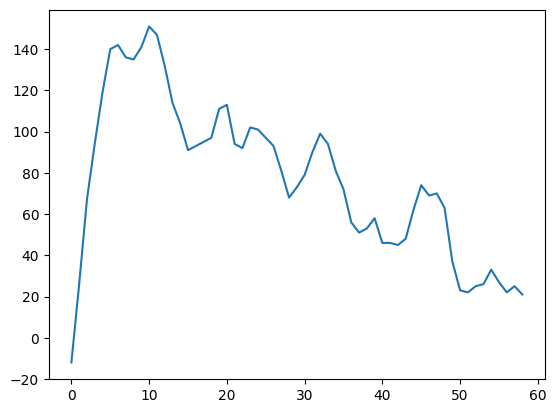

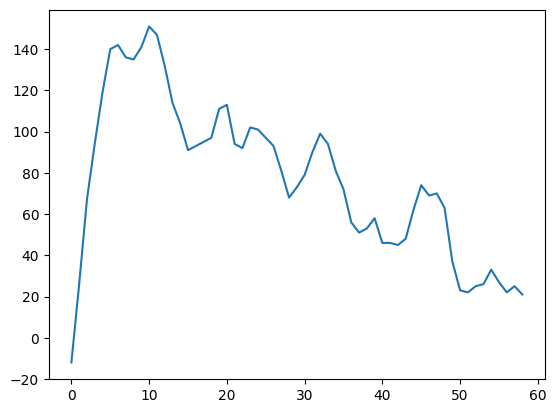

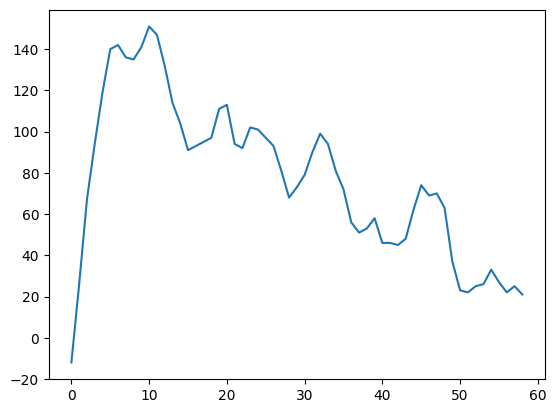

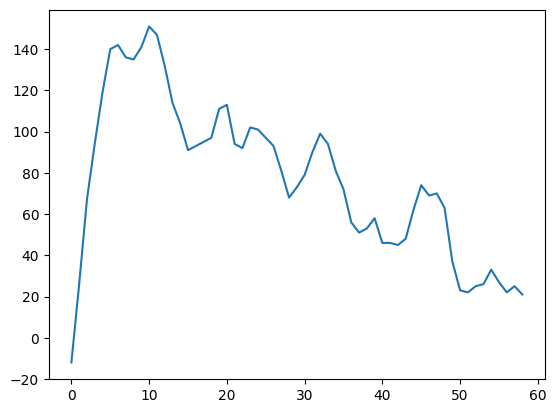

(500, 195)
(500, 7)
(500, 194)
(500, 7)
(500, 191)
(500, 7)


<ipython-input-8-b085d51e20a8>:14: RuntimeWarning: invalid value encountered in scalar divide
  prompt_fraction.append( np.sum(pr)/ np.sum(ali))


(500, 195)
(500, 7)
(500, 189)
(500, 7)
(500, 181)
(500, 7)
(500, 186)
(500, 7)
(500, 190)
(500, 7)
(500, 183)
(500, 7)
(500, 187)
(500, 7)
(500, 197)
(500, 7)
(500, 196)
(500, 7)
(500, 185)
(500, 7)
(129, 181)
(129, 7)


In [ ]:
filename = '/content/drive/MyDrive/lab_adi/adc_data_run_25087_ch_37_all.npy'
chunk_size = 500
output_file = '/content/drive/MyDrive/lab_adi/processed_data_negative.csv'

for i, chunk in enumerate(load_in_chunks(filename, chunk_size, 0, None)):
    processed_chunk = prompt_calculation(chunk)
    print(processed_chunk.shape)
    processed_chunk.to_csv(output_file, mode='a', header=False, index=False)

In [ ]:
output_file_pos = '/content/drive/MyDrive/lab_adi/processed_data_positive.csv'
output_file_neg = '/content/drive/MyDrive/lab_adi/processed_data_negative.csv'


positive_df_features = pd.read_csv(output_file_pos).fillna(0)
negative_df_features = pd.read_csv(output_file_neg).fillna(0)

print(positive_df_features.shape)
print(negative_df_features.shape)

(74721, 7)
(75672, 7)


In [ ]:
negative_df_features = negative_df_features.iloc[0:positive_df_features.shape[0],:]
print(positive_df_features.shape)
print(negative_df_features.shape)

(74721, 7)
(74721, 7)


In [ ]:
from scipy.stats import gaussian_kde

def get_density(x, y):
    xy = np.vstack([x, y])
    density = gaussian_kde(xy, bw_method=0.2)(xy)
    return density

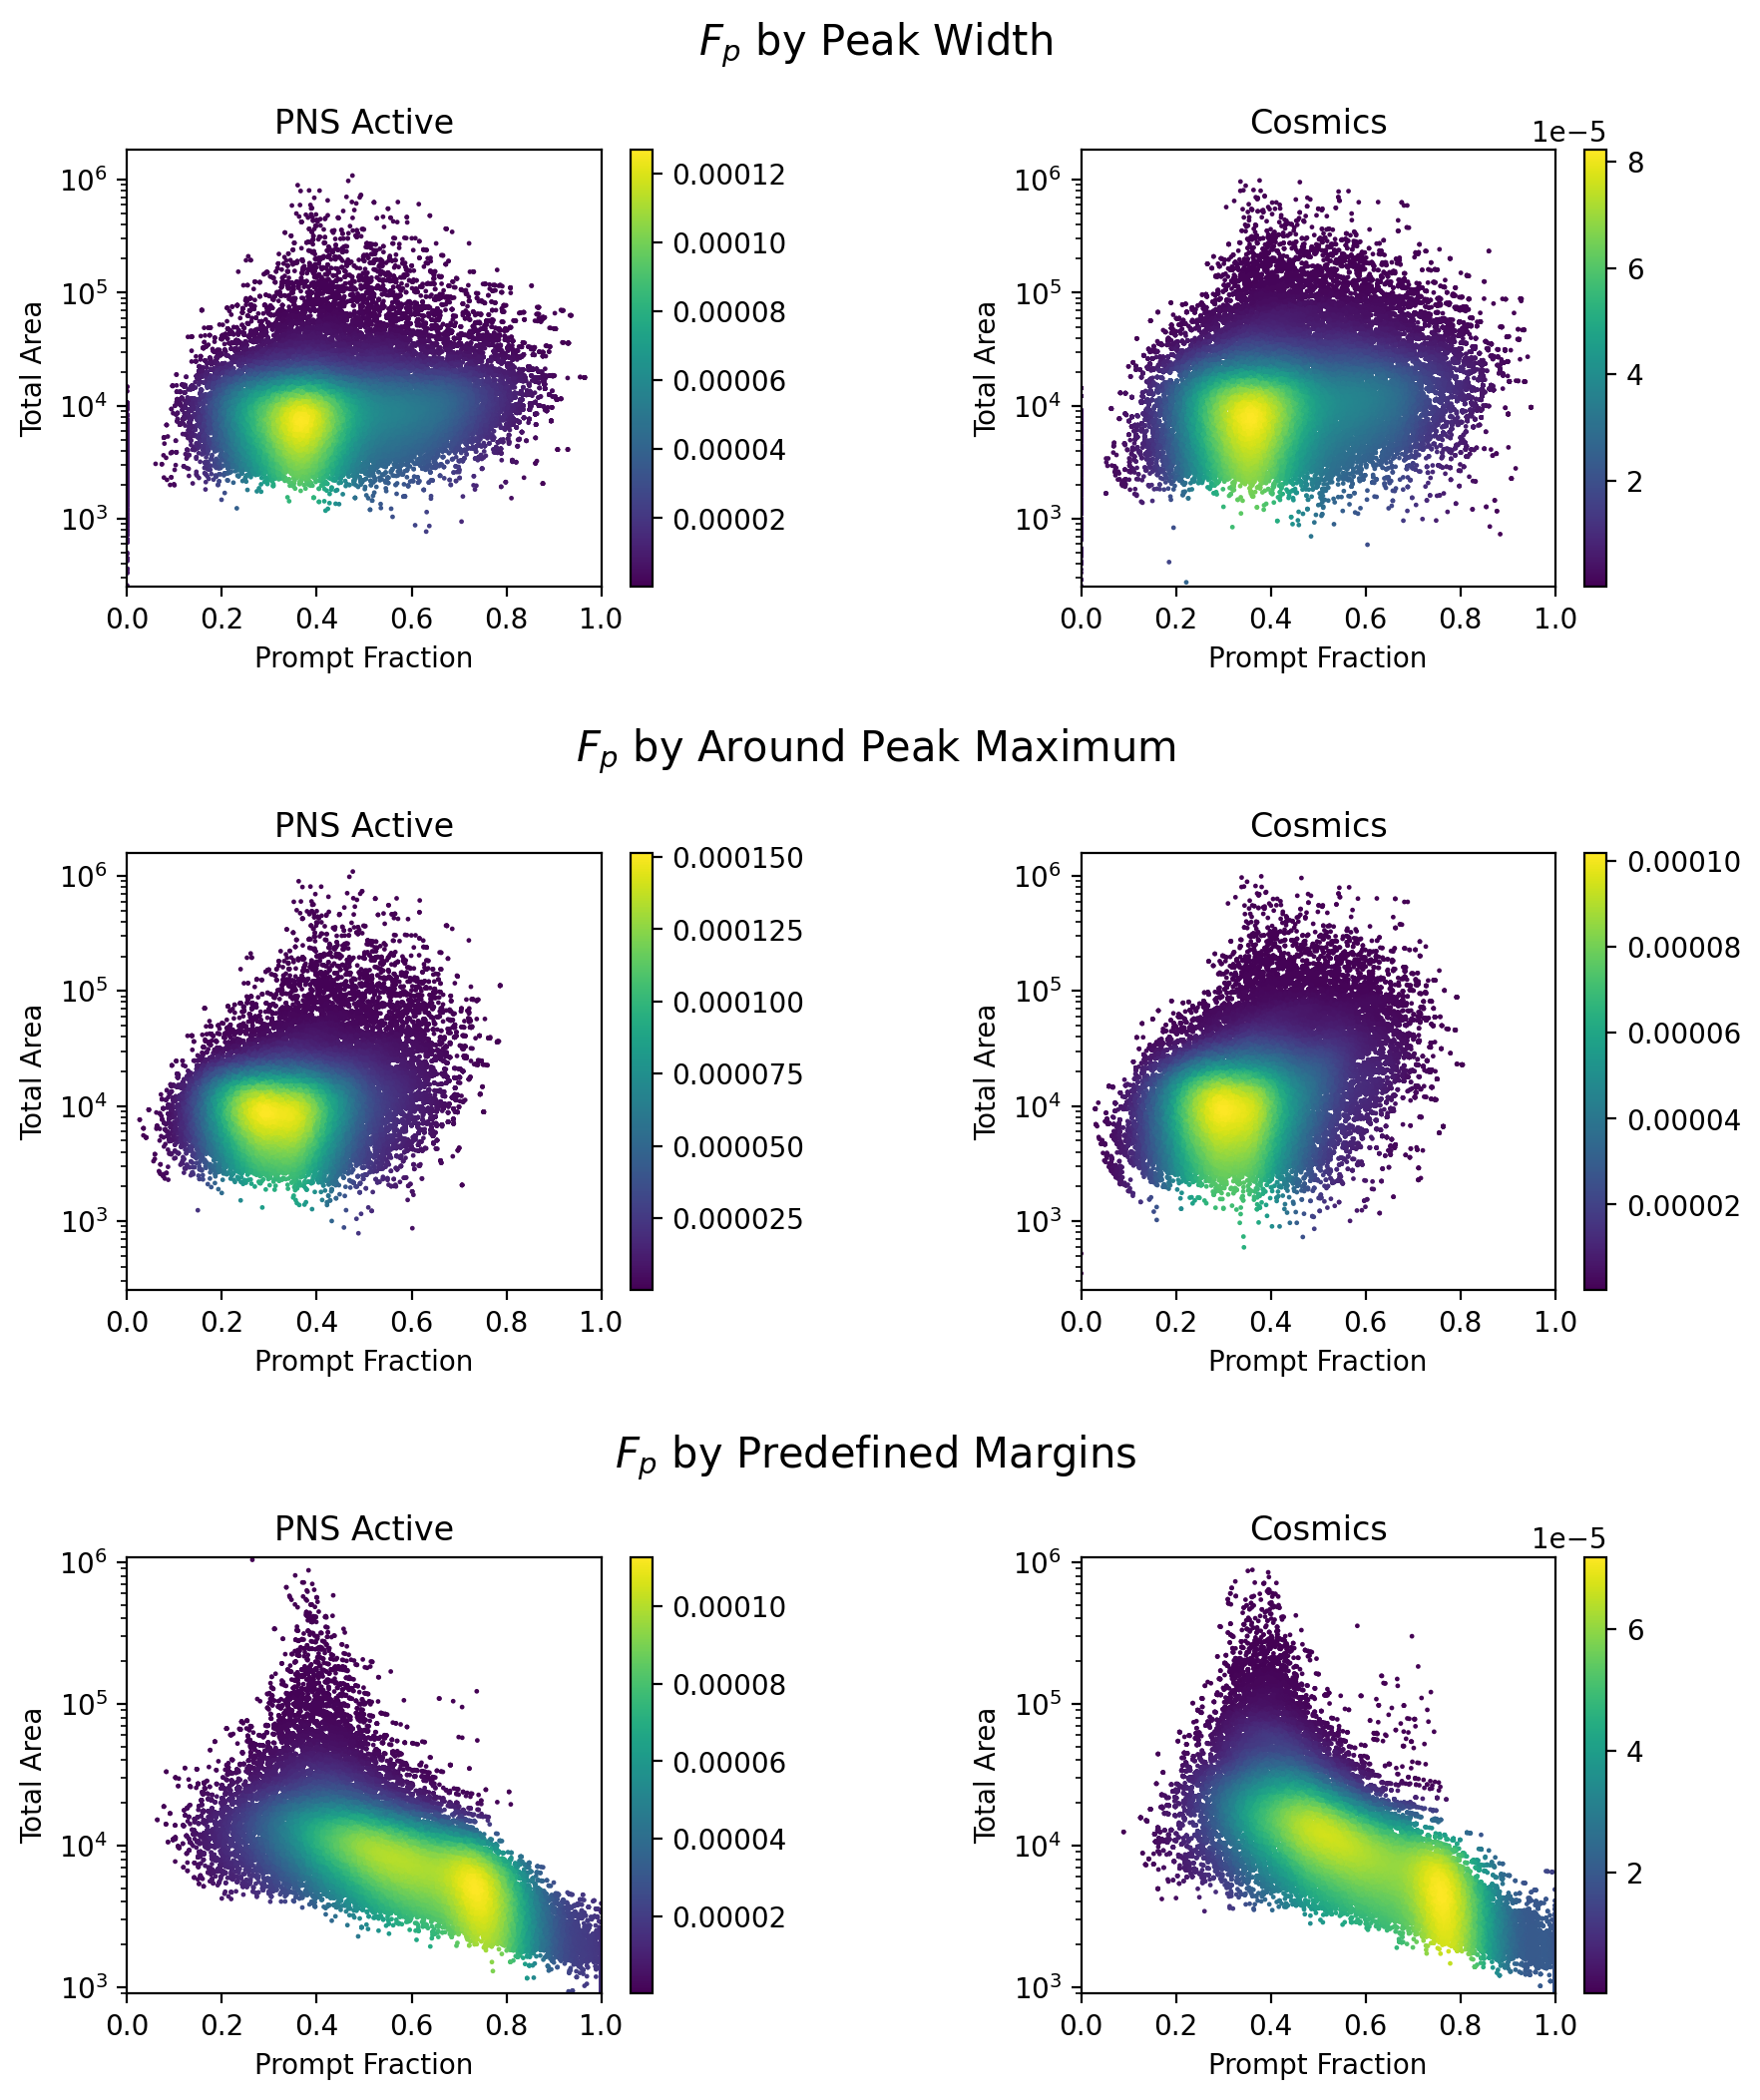

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 12), dpi=200)

# First row plots
density00 = get_density(positive_df_features.iloc[:, 0], positive_df_features.iloc[:, 1])
density01 = get_density(negative_df_features.iloc[:, 0], negative_df_features.iloc[:, 1])
sc00 = axs[0, 0].scatter(positive_df_features.iloc[:, 0], positive_df_features.iloc[:, 1], s=0.5, c=density00, cmap='viridis')
axs[0, 0].set_title('PNS Active')
axs[0, 0].set_xlim([0, 1])
axs[0, 0].set_yscale('log')
axs[0, 0].set_ylim(250, None)

sc01 = axs[0, 1].scatter(negative_df_features.iloc[:, 0], negative_df_features.iloc[:, 1], s=0.5, c=density01, cmap='viridis')
axs[0, 1].set_title('Cosmics')
axs[0, 1].set_xlim([0, 1])
axs[0, 1].set_yscale('log')

axs[0, 0].set_xlabel('Prompt Fraction')
axs[0, 0].set_ylabel('Total Area')
axs[0, 1].set_xlabel('Prompt Fraction')
axs[0, 1].set_ylabel('Total Area')

axs[0, 1].set_ylim(axs[0, 0].get_ylim())

# Second row plots
density10 = get_density(positive_df_features.iloc[:, 2], positive_df_features.iloc[:, 3])
density11 = get_density(negative_df_features.iloc[:, 2], negative_df_features.iloc[:, 3])
sc10 = axs[1, 0].scatter(positive_df_features.iloc[:, 2], positive_df_features.iloc[:, 3], s=0.5, c=density10, cmap='viridis')
axs[1, 0].set_title('PNS Active')
axs[1, 0].set_xlim([0, 1])
axs[1, 0].set_yscale('log')
axs[1, 0].set_ylim(250, None)
sc11 = axs[1, 1].scatter(negative_df_features.iloc[:, 2], negative_df_features.iloc[:, 3], s=0.5, c=density11, cmap='viridis')
axs[1, 1].set_title('Cosmics')
axs[1, 1].set_xlim([0, 1])
axs[1, 1].set_yscale('log')

axs[1, 0].set_xlabel('Prompt Fraction')
axs[1, 0].set_ylabel('Total Area')
axs[1, 1].set_xlabel('Prompt Fraction')
axs[1, 1].set_ylabel('Total Area')

axs[1, 1].set_ylim(axs[1, 0].get_ylim())


# Third row plots
density20 = get_density(positive_df_features.iloc[:, 5], positive_df_features.iloc[:, 6])
density21 = get_density(negative_df_features.iloc[:, 5], negative_df_features.iloc[:, 6])
sc20 = axs[2, 0].scatter(positive_df_features.iloc[:, 5], positive_df_features.iloc[:, 6], s=0.5, c=density20, cmap='viridis')
axs[2, 0].set_title('PNS Active')
axs[2, 0].set_xlim([0, 1])
axs[2, 0].set_ylim(900, None)
axs[2, 0].set_yscale('log')
sc21 = axs[2, 1].scatter(negative_df_features.iloc[:, 5], negative_df_features.iloc[:, 6], s=0.5, c=density21, cmap='viridis')
axs[2, 1].set_title('Cosmics')
axs[2, 1].set_xlim([0, 1])
#axs[2, 0].set_ylim(10e2, None)
axs[2, 1].set_yscale('log')

axs[2, 0].set_xlabel('Prompt Fraction')
axs[2, 0].set_ylabel('Total Area')
axs[2, 1].set_xlabel('Prompt Fraction')
axs[2, 1].set_ylabel('Total Area')

axs[2, 1].set_ylim(axs[2,0].get_ylim())

# Set titles for each row
fig.text(0.5, 0.92, '$F_{p}$ by Peak Width', ha='center', fontsize=15)
fig.text(0.5, 0.625, '$F_{p}$ by Around Peak Maximum', ha='center', fontsize=15)
fig.text(0.5, 0.33, '$F_{p}$ by Predefined Margins', ha='center', fontsize=15)

fig.colorbar(sc00, ax=axs[0, 0])
fig.colorbar(sc01, ax=axs[0, 1])
fig.colorbar(sc10, ax=axs[1, 0])
fig.colorbar(sc11, ax=axs[1, 1])
fig.colorbar(sc20, ax=axs[2, 0])
fig.colorbar(sc21, ax=axs[2, 1])


# Adjust layout
plt.subplots_adjust(hspace=0.61)  # Increase the vertical space between rows
plt.subplots_adjust(wspace=0.61)
#plt.tight_layout(rect=[0, 0, 1, 0.93])  # Adjust for titles above
plt.show()


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 6], dpi=200)
fig.suptitle('Prompt Fraction by Predefined Margins', fontsize=16)
# Plot for positive_df_features
ax1.scatter(positive_df_features.iloc[:, 0], positive_df_features.iloc[:, 1], s=0.5)

# For negative_df_features, use the index as the y-axis values to see all points
ax2.scatter(negative_df_features.iloc[:, 0], negative_df_features.iloc[:, 1], s=0.5)
#print(negative_df_features.iloc[:, 3:5])
print(positive_df_features.groupby(['Prompt1', 'All1']).size())
# Set axis labels
ax1.title.set_text('PNS Active')
ax2.title.set_text('Cosmics')
ax1.set_xlabel('Prompt Fraction')
ax1.set_ylabel('Total Area')
ax1.set_xlim([0, 1])
ax1.set_yscale('log')

ax2.set_xlabel('Prompt Fraction')
ax2.set_ylabel('Total Area')
ax2.set_xlim([0, 1])
ax2.set_ylim(ax1.get_ylim())
ax2.set_yscale('log')


plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[16, 6], dpi=200)
ax1.plot(positive_df_features.iloc[:, 4])
ax2.plot(negative_df_features.iloc[:, 4])
plt.show()

In [ ]:
import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 1. Mean and Standard Deviation
prompt_pos = positive_df_features.iloc[:, 5]
all_pos = positive_df_features.iloc[:, 6]
prompt_neg = negative_df_features.iloc[:, 5]
all_neg = negative_df_features.iloc[:, 6]

mean_pos = np.mean(prompt_pos), np.mean(all_pos)
mean_neg = np.mean(prompt_neg), np.mean(all_neg)

std_pos = np.std(prompt_pos), np.std(all_pos)
std_neg = np.std(prompt_neg), np.std(all_neg)

print(f"Mean (Pos): {mean_pos}, Std Dev (Pos): {std_pos}")
print(f"Mean (Neg): {mean_neg}, Std Dev (Neg): {std_neg}")

# 2. Pearson Correlation Coefficient
corr_pos = np.corrcoef(prompt_pos, all_pos)[0, 1]
corr_neg = np.corrcoef(prompt_neg, all_neg)[0, 1]

print(f"Pearson Correlation (Pos): {corr_pos}")
print(f"Pearson Correlation (Neg): {corr_neg}")

# 3. Kolmogorov-Smirnov Test
ks_test_x = stats.ks_2samp(prompt_pos, prompt_neg)
ks_test_y = stats.ks_2samp(all_pos, all_neg)

print(f"KS Test (Prompt1-Pos vs Prompt1-Neg): {ks_test_x}")
print(f"KS Test (All1-Pos vs All1-Neg): {ks_test_y}")

# 4. Outlier Detection using Z-scores
z_scores_pos = np.abs(stats.zscore(np.vstack((prompt_pos, all_pos)).T, axis=0))
z_scores_neg = np.abs(stats.zscore(np.vstack((prompt_neg, all_neg)).T, axis=0))

outliers_pos = np.where(z_scores_pos > 3)
outliers_neg = np.where(z_scores_neg > 3)

print(f"Number of outliers (Pos): {len(outliers_pos[0])}")
print(f"Number of outliers (Neg): {len(outliers_neg[0])}")